In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from fdm import derivative_matrix
from fdm_integrals import backward_euler_int, trapezoids_int
from numerical_integral import compute_integral
from rates import make_b, make_sigma2
from params import ex_params_1

In [3]:
b = make_b(ex_params_1)
sigma2 = make_sigma2(ex_params_1)

In [81]:
# Parametry dla rozwiązywania RRCz
n = 1000                   # liczba kroków w przestrzeni
h = ex_params_1.n_star/n   # dł. kroku w przestrzeni
tau = 0.1                  # dł. kroku w czasie
tol = 10**-12               # tolerancja w całkowaniu funkcji u

# Dla numerycznego obliczania wartości oczekiwanej bierzemy mniejszy krok
int_step = h / 10
int_n = n * 10

In [82]:
# Obliczamy numerycznie wartość oczekiwaną
num_int_linspace, num_int = compute_integral(int_step, int_n, ex_params_1)

In [83]:
# Całkujemy w locie funkcje otrzymanie z rozwiązywania RRCz
d_m, special = derivative_matrix(b, sigma2, h, n)
u_0 = np.ones(n)
int_u_euler = backward_euler_int(u_0, d_m, tau, tol)
#int_u_trapezoids = trapezoids_int(u_0, d_m, special, tau, tol)

Zakończono całkowanie w momencie 2222.0, po 22220 iteracji.
Zakończono całkowanie w momencie 6330.5, po 63305 iteracji.


In [84]:
pde_linspace = np.linspace(0, ex_params_1.n_star-h, len(int_u_euler))

In [85]:
# Sprawdzam które elementy w numerycznej wartości oczekiwanej
# i w całce z rozwiązania RRCz sobie odpowiadają
np.allclose(num_int_linspace[9::10][:-1], pde_linspace[1:])

True

In [86]:
# Przycinam wyniki
linspace = num_int_linspace[9::10][:-1]
num_int = num_int[9::10][:-1]
int_u_euler = int_u_euler[1:]
int_u_trapezoids = int_u_trapezoids[1:]

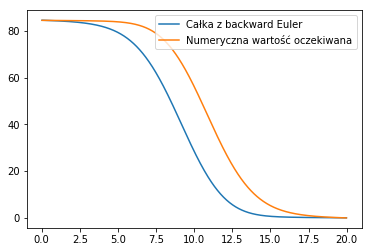

In [88]:
plt.plot(linspace, int_u_euler)
#plt.plot(linspace, int_u_trapezoids)
plt.plot(linspace, num_int)
plt.legend(["Całka z backward Euler", "Numeryczna wartość oczekiwana"])

In [89]:
np.mean((num_int-int_u_euler)**2)

172.6196322147001